# Homework problem: cat states in circuit QED

In circuit quantum electrodynamics (cQED), it is relatively easy to achieve the *strong dispersive limit* for a microwave resonator (cavity) coupled to a superconductive qubit. We'll skip over subtle, but important, details and consider a bipartite system consisting of a harmonic oscillator coupled to a two-level system.

Your goal is to start from the system in the ground state
$$\left| \psi_\mathrm{i} \right> = \left|0\right> \otimes \left| \mathrm{g} \right>$$
and end up with the system in a quantum superposition of coherent states, a.k.a. a cat state
$$\left| \psi_\mathrm{f} \right> = \frac{1}{\sqrt{2}}\left[ \left|\alpha\right> + \left|-\alpha\right> \right] \otimes \left| \mathrm{g} \right>$$
by applying appropriate drive signals to the cavity and to the qubit while the system evolves in time.

In [1]:
# Defining some helpful functions that will be used later

import numpy as np
import matplotlib.pyplot as plt
from qutip import *


def visualize_wigner(psi, alpha, title="Wigner Function"):

    rho_cavity = psi.ptrace(0)  # Partial trace over qubit
    xvec = np.linspace(-3*int(alpha), 3*int(alpha), int(alpha)*100)
    wigner_cavity = wigner(rho_cavity, xvec, xvec)
    wlim = np.abs(wigner_cavity).max()
    
    plt.imshow(
        wigner_cavity, cmap='RdBu_r', vmin=-wlim, vmax=wlim, origin="lower",
        extent=(xvec.min(), xvec.max(), xvec.min(), xvec.max()),
    )
    plt.axhline(0.0, c="tab:gray", alpha=0.25)
    plt.axvline(0.0, c="tab:gray", alpha=0.25)
    # plt.contourf(xvec, xvec, wigner_cavity, levels=100, cmap='RdBu')
    plt.title(title)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$p$")
    plt.colorbar()
    plt.show()

def wigner_evolution(psi, ns):
    
    fig4, ax4 = plt.subplots(2, 5, sharex=True, sharey=True)
    ax4 = ax4.flatten()
    xvec = np.linspace(-7, 7, 200)
    
    for axi, idx in enumerate(range(0, ns, ns//10)):
        rho = psi.states[idx]
        W = wigner(rho.ptrace(0), xvec, xvec)
        wlim = np.abs(W).max()
        ax4[axi].imshow(
            W, cmap='RdBu_r', vmin=-wlim, vmax=wlim, origin="lower",
            extent=(xvec.min(), xvec.max(), xvec.min(), xvec.max()),
        )
        ax4[axi].axhline(0.0, c="tab:gray", alpha=0.25)
        ax4[axi].axvline(0.0, c="tab:gray", alpha=0.25)
        ax4[axi].set_title(f"t = {tlist[idx]:.2f} ns")
    
    [ax4[axi].set_xlabel(r"$x$") for axi in [4, 5, 6, 7]]
    [ax4[axi].set_ylabel(r"$p$") for axi in [0, 4]]

    
def visualize_bloch(psi):
    rho_qubit = psi.ptrace(1)  # Partial trace over the cavity
    bloch = Bloch()
    bloch.add_states(rho_qubit)
    bloch.show()

### **Step 1: Define System Parameters**

We start with the initial state as given below,
$$\left| \psi_\mathrm{0} \right> = \left|0\right> \otimes \left| \mathrm{g} \right>$$
here cavity and qubit both are in ground state. Having cavity-qubit detuning $\Delta = \omega_\mathrm{Q} - \omega_\mathrm{C}$ to be much larger than the coupling strength $g$ is required for rotating wave approximation, which will be used later. It should still be small enough to not introduce extra modes. Therefore, we choose the resonator and qubit resonance frequencies as 6 GHz and 5 GHz, respectively. We can't choose Hilbert state cut off ($N$) to be infinite, therefore we choose a value such that it covers most of the possible states, N=30 and choosing $\alpha = 2$, $\left< n \right> = 8$.

In [2]:
# Step 1: Define parameters
wc = 6.0 * 2 * np.pi  # Resonator frequency (GHz -> rad/s)
wq = 5.0 * 2 * np.pi  # Qubit frequency (GHz -> rad/s)
g = 0.1 * 2 * np.pi    # Coupling strength (GHz -> rad/s)
delta = wc - wq
chi = g**2 / delta # Dispersive shift (GHz -> rad/s)
kappa = 0.01 * 2 * np.pi  # Cavity dissipation rate (GHz -> rad/s)
gamma = 0.01 * 2 * np.pi  # Qubit dissipation rate (GHz -> rad/s)
alpha = 2  # Coherent state amplitude
N = 30

# Cavity operators
a = tensor(destroy(N), qeye(2))  # annihilation
n = a.dag() * a  # photon number
x = tensor(position(N), qeye(2))  # x = 1/sqrt(2) * (a + a.dag())
p = tensor(momentum(N), qeye(2))  # p = -1j/sqrt(2) * (a - a.dag())
# with these definitions: <x>^2 / 2 + <p>^2 / 2 = <n>

# Qubit operators (Pauli matrices)
sx = tensor(qeye(N), sigmax())  # sp + sm
sy = tensor(qeye(N), sigmay())  # 1j * (sm - sp)
sz = tensor(qeye(N), sigmaz())
sp = tensor(qeye(N), sigmap())  # (sx + 1j * sy) / 2 == sm.dag()
sm = tensor(qeye(N), sigmam())  # (sx - 1j * sy) / 2 == sp.dag()

# identity matrix
eye = tensor(qeye(N), qeye(2))

# Initial state
psi0 = tensor(basis(N, 0), basis(2, 1))  # |0>|g>

print(f"System parameters:\nCavity frequency: {wc / (2 * np.pi)} GHz\nQubit frequency: {wq / (2 * np.pi)} GHz")
print(f"Hilbert space cutoff: {N}")

System parameters:
Cavity frequency: 6.0 GHz
Qubit frequency: 5.0 GHz
Hilbert space cutoff: 30


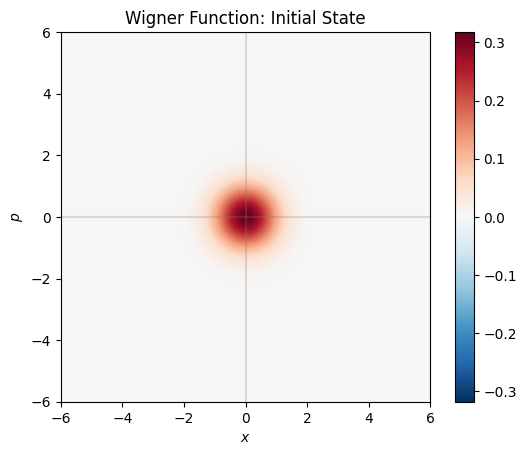

In [3]:
visualize_wigner(psi0, alpha, title="Wigner Function: Initial State")

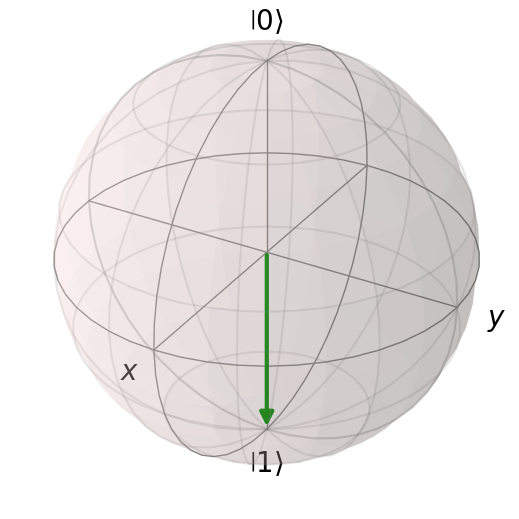

In [4]:
visualize_bloch(psi0)

Initial state of cavity and qubit can be seen in the above visualizations. Cavity shows a gaussian blob at the center and qubit points to ground state in the Bloch sphere.

---

### **Step 2: Apply a π/2 Pulse to the Qubit**
Hamiltonian for this steps looks like below.
$$H = H_0 + V + H_\mathrm{D}$$
$$H_0 = \hbar \omega_\mathrm{C} \left( a^\dagger a + \frac{1}{2}\right) + \frac{1}{2} \hbar \omega_\mathrm{Q} \sigma_\mathrm{z}$$
and the interaction Hamiltonian $V$ is the Jaynes-Cummings term \[see Eq. (3.316) from Girvin's notes\]:
$$V_\mathrm{JC} = \hbar g \left(a^\dagger + a\right) \left(\sigma_+ + \sigma_- \right) = \sqrt{2} \hbar g x \sigma_\mathrm{x}$$

In the rotating-wave approximation, we neglect the terms proportional to $a\sigma_-$ and $a^\dagger\sigma_+$ that rotate rapidly at frequencies $\pm\left(\omega_\mathrm{C} + \omega_\mathrm{Q}\right)$, and only keep the terms rotating slowly at  $\pm\left(\omega_\mathrm{C} - \omega_\mathrm{Q}\right)$ \[see Eq. (3.322) from Girvin's notes\]:
$$V_\mathrm{RWA} = \hbar g \left(a\sigma_+ + a^\dagger\sigma_-\right)$$

and the drive signal for the qubit, $H_\mathrm{D}$, is given by
$$H_\mathrm{D} = d(t) \sigma_\mathrm{x}$$
where $d(t)$ is a time-dependent drive term.

For a drive term of the form
$$d(t) = A \cos\left( \omega_\mathrm{D} t + \phi \right) = \frac{A}{2} \left[ \mathrm{e}^{\mathrm{i}\left( \omega_\mathrm{D} t + \phi \right)} + \mathrm{e}^{-\mathrm{i}\left( \omega_\mathrm{D} t + \phi \right)} \right]$$
we can invoke the rotating-wave approximation (with the usual caveats) and drop the fast-rotating terms at $\pm\left(\omega_\mathrm{D}+\omega_\mathrm{Q}\right)$:
$$H_\mathrm{D} = \frac{1}{2} \left[ \sigma_- \tilde{d}(t) + \sigma_+ \tilde{d}^*(t) \right]$$
where $\tilde{d}(t) = \mathrm{e}^{\mathrm{i}\left( \omega_\mathrm{D} t + \phi \right)}$.

This approximation speeds up the numerical integration, because the solver doesn't need to keep track of the very fast dynamics.

In [5]:
# Time array
fs = 120.0  # sampling frequency, GHz
dt = 1 / fs
T = 0.51  # time, ns
ns = int(round(fs * T))  # nr of samples
tlist = dt * np.arange(ns)  # nanoseconds
USE_RWA = True

wd = wq + chi # drive at the qubit transition frequency
amp = np.pi
phase = -np.pi / 2

if USE_RWA:
    drive = amp * np.exp(1j * (wd * tlist + phase))
    V = g * (a.dag() + a) * (sp + sm)
else:
    drive = amp * np.cos(wd * tlist + phase)
    V = g * (a * sp + a.dag() * sm)

# Hamiltonian
H0 = wc * (a.dag() * a + eye / 2) + 0.5 * wq * sz
H = [
    H0,
    V,
    [sm, 0.5 * drive],
    [sp, 0.5 * drive.conj()],
]

psi1 = sesolve(H, psi0, tlist)

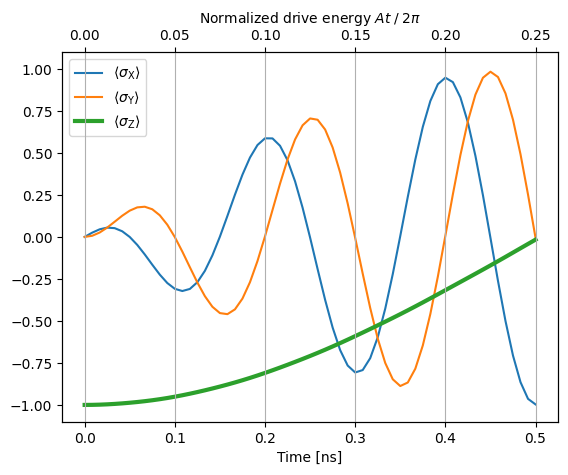

In [6]:
fig2, ax2 = plt.subplots()
ax2.plot(tlist, expect(sx, psi1.states), label=r"$\left<\sigma_\mathrm{X}\right>$")
ax2.plot(tlist, expect(sy, psi1.states), label=r"$\left<\sigma_\mathrm{Y}\right>$")
ax2.plot(tlist, expect(sz, psi1.states), lw=3, label=r"$\left<\sigma_\mathrm{Z}\right>$")
ax2.set_ylim(-1.1, 1.1)
ax2.set_xlabel(r"Time [ns]")
ax2.legend(loc="upper left")

# alternative x scale on top
ax2t = ax2.twiny()
lim_b = ax2.get_xlim()
lim_t = (amp * lim_b[0] / 2 / np.pi, amp * lim_b[1] / 2 / np.pi)
ax2t.set_xlim(lim_t)
ax2t.set_xlabel(r"Normalized drive energy $A t \;/\; 2 \pi$")
ax2t.grid(axis='x')

Above plot shows the evolution of the qubit from ground state to superposition state.

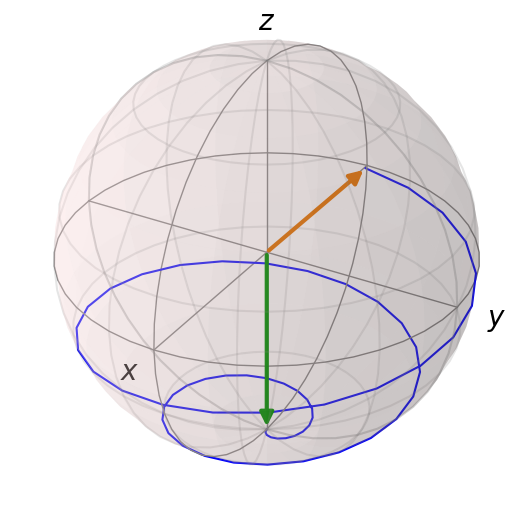

In [7]:
points = np.zeros((3, 61))
points[0, :] = expect(sx, psi1.states)
points[1, :] = expect(sy, psi1.states)
points[2, :] = expect(sz, psi1.states)

sphere = Bloch()
sphere.add_states(psi1.states[0].ptrace(1))
sphere.add_states(psi1.states[-1].ptrace(1))
sphere.add_points(points, meth='l')

sphere.set_label_convention("xyz")
sphere.make_sphere()
sphere.show()

A $\pi/2$ pulse rotates the qubit state by 90° around the Bloch sphere, placing it in a superposition. The pulse is applied resonantly with the qubit’s transition frequency. The final state the of system will be given by,

$$\left| \psi_1 \right> = \frac{1}{\sqrt{2}} \left|0\right> \otimes \left[ \left| \mathrm{g} \right> + \left| \mathrm{e} \right> \right].$$

---

### **Step 3: Conditional Displacement of the Cavity**

For conditional displacement of the cavity when the qubit is in ground state, we drive the cavity with frequency corresponding to the ground state of the qubit, which is $\omega_\mathrm{C} - \chi$.


In [8]:
T0 = round(abs(2*np.pi / chi)-5)

# Time array
fs = 120.0  # sampling frequency, GHz
dt = 1 / fs
T = T0
ns = int(round(fs * T))  # nr of samples
tlist = dt * np.arange(ns)  # nanoseconds

# Cavity drive
wd_c = wc - chi  # drive at the frequency corresponding to ground state
amp_c = 0.16
phase_c = -np.pi / 2
drive_c = amp_c * np.sin(np.pi / T * tlist)**2 * np.exp(1j * (wd_c * tlist + phase_c))

# Hamiltonian
H0 = wc * (a.dag() * a + eye / 2) + 0.5 * wq * sz
V = chi * (a.dag() * a + eye / 2) * sz  # dispersive interaction

H = [
    H0,
    V,
    #[a * sp, g * np.exp(1j * delta * tlist)],
    #[a.dag() * sm, g * np.exp(-1j * delta * tlist)],
    [a, 0.5 * drive_c],
    [a.dag(), 0.5 * drive_c.conj()],
]

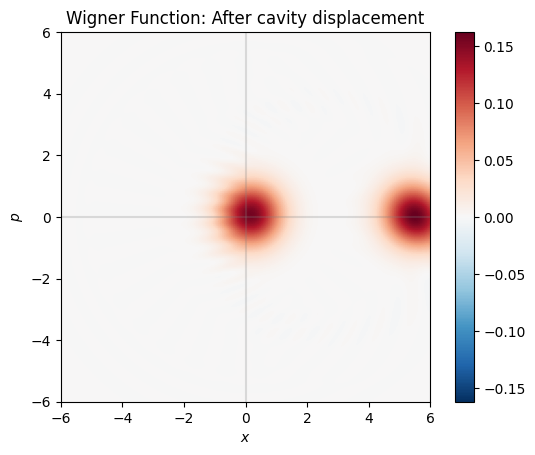

In [9]:
psi2 = sesolve(H, psi1.states[-1], tlist)

visualize_wigner(psi2.states[-1], alpha, title="Wigner Function: After cavity displacement")

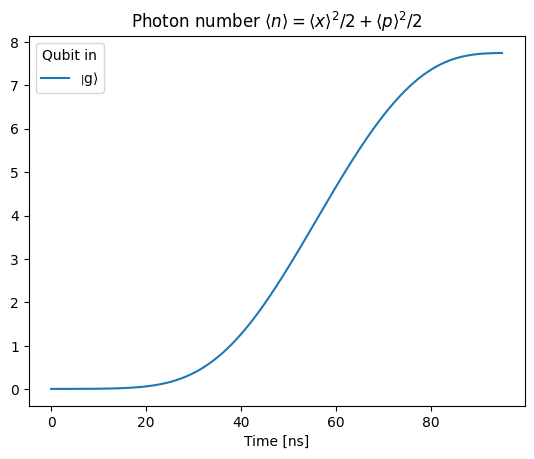

In [10]:
fig5, ax5 = plt.subplots(1, 1)

# Plot photon number
ax5.plot(tlist, expect(n, psi2.states), c="tab:blue", label=r"$\left|\mathrm{g}\right>$")
ax5.set_xlabel("Time [ns]")
ax5.set_title(r"Photon number $\left< n \right>= \left<x\right>^2/2 + \left<p\right>^2/2$")
ax5.legend(title="Qubit in")

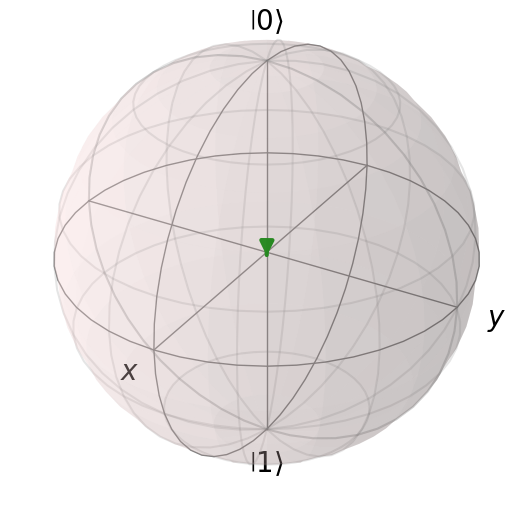

In [11]:
visualize_bloch(psi2.states[-1])

After cavity displacement we get an entangled state ($\psi_2$):
    $$\left| \psi_2 \right> = \frac{1}{\sqrt{2}} \left[ \left|2\alpha\right> \otimes \left| \mathrm{g} \right> + \left|0\right> \otimes \left| \mathrm{e} \right> \right].$$

Here, $\alpha = 2$



---

### **Step 4: Conditional Qubit Flip**

In [12]:
sigma = 5/(4*np.abs(alpha)**2*chi)

def gaussian(t, args):
    sigma = args['sigma']
    return np.exp(-((t-4*sigma)/sigma)**2/2)


def applyGaus(psi0, amp, sigma):
    args = {'sigma': sigma}
    tlist = np.linspace(0, 8*sigma, 201)
    result = mesolve(H=[H0, [amp*sy, gaussian]], rho0=psi0, tlist=tlist,
                        c_ops=[np.sqrt(kappa)*a, np.sqrt(gamma)*sm],
                        e_ops=[], args=args)
    return result

psi3 = applyGaus(psi2.states[-1], np.sqrt(np.pi/8)/sigma, sigma)

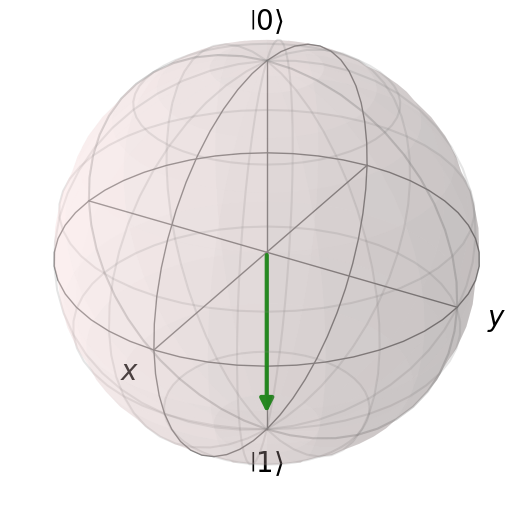

In [13]:
visualize_bloch(psi3.states[-1])

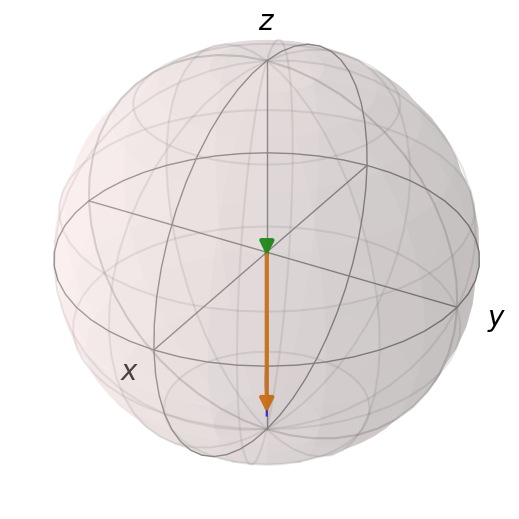

In [14]:
points = np.zeros((3, 201))
points[0, :] = expect(sx, psi3.states)
points[1, :] = expect(sy, psi3.states)
points[2, :] = expect(sz, psi3.states)

sphere = Bloch()
sphere.add_states(psi3.states[0].ptrace(1))
sphere.add_states(psi3.states[-1].ptrace(1))
sphere.add_points(points, meth='l')

sphere.set_label_convention("xyz")
sphere.make_sphere()
sphere.show()

New state is given by: 
$$\left| \psi_3 \right> = \frac{1}{\sqrt{2}} \left[ \left|2\alpha\right> + \left|0\right> \right] \otimes \left| \mathrm{g} \right>.$$


---

### **Step 5: Final Displacement**

In [15]:
# Step 5: Final displacement
T0 = round(abs(2*np.pi / chi))

# Time array
fs = 240.0  # sampling frequency, GHz
dt = 1 / fs
T = T0
ns = int(round(fs * T))  # nr of samples
tlist = dt * np.arange(ns)  # nanoseconds

# Cavity drive
wd_c = wc  
amp_c = 0.04
phase_c = -np.pi / 2
drive_c = -amp_c * np.sin(np.pi / T * tlist)**2 * np.exp(1j * (wd_c * tlist + phase_c))

# Hamiltonian
H0 = wc * (a.dag() * a + eye / 2) + 0.5 * wq * sz
V = chi * (a.dag() * a + eye / 2) * sz  # dispersive interaction

H = [
    H0,
    V,
    [a, 0.5 * drive_c],
    [a.dag(), 0.5 * drive_c.conj()],
]

psi4 = sesolve(H, psi3.states[-1], tlist)

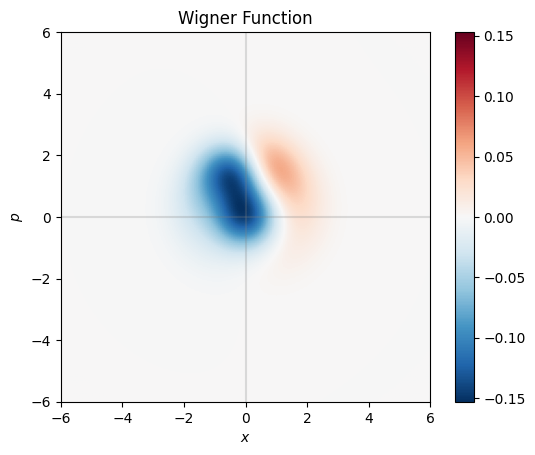

In [16]:
visualize_wigner(psi4.states[-1], alpha)